In [25]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Linear combination of unitaries and block encodings
===================================================

If I (Juan Miguel) had to summarize quantum computing in one sentence,
it would be this: information is encoded in quantum states and processed
using [unitary
operations](https://pennylane.ai/codebook/01-introduction-to-quantum-computing/03-unitary-matrices/).
The challenge of quantum algorithms is to design and build these
unitaries to perform interesting and useful tasks with the encoded
information. My colleague [Nathan
Wiebe](https://scholar.google.ca/citations?user=DSgKHOQAAAAJ&hl=en) once
told me that some of his early research was motivated by a simple
question: Quantum computers can implement products of unitaries \-\--
after all, that\'s how we build circuits from a [universal gate
set](https://pennylane.ai/codebook/02-single-qubit-gates/04-universal-gate-sets/).
But what about **sums of unitaries**? 🤔

In this tutorial, we will teach you the basics of one of the most
versatile tools in quantum algorithms: *linear combinations of
unitaries*, or LCUs for short. You will also understand how to use LCUs
to create another powerful building block of quantum algorithms: block
encodings. Among their many uses, block encodings allow us to transform
quantum states by non-unitary operators, and they are useful in a
variety of contexts, perhaps most famously in
[qubitization](https://arxiv.org/abs/1610.06546) and the [quantum
singular value transformation
(QSVT)](https://pennylane.ai/qml/demos/tutorial_intro_qsvt).

| 

![](../_static/demonstration_assets/lcu_blockencoding/thumbnail_lcu_blockencoding.png){.align-center
width="50.0%"}

| 

LCUs
----

Linear combinations of unitaries are straightforward \-\-- it's already
explained in the name: we decompose operators into a weighted sum of
unitaries. Mathematically, this means expressing an operator $A$ in
terms of coefficients $\alpha_{k}$ and unitaries $U_{k}$ as

$$A =  \sum_{k=0}^{N-1} \alpha_k U_k.$$

A general way to build LCUs is to employ properties of the **Pauli
basis**. This is the set of all products of Pauli matrices
$\{I, X, Y, Z\}$. For the space of operators acting on $n$ qubits, this
set forms a complete basis. Thus, any operator can be expressed in the
Pauli basis, which immediately gives an LCU decomposition. PennyLane
allows you to decompose any matrix into the Pauli basis using the
`~.pennylane.pauli_decompose`{.interpreted-text role="func"} function.
The coefficients $\alpha_k$ and the unitaries $U_k$ from the
decomposition can be accessed directly from the result. We show how to
do this in the code below for a simple example.


In [26]:
import numpy as np
import pennylane as qml

a = 0.25
b = 0.75

# matrix to be decomposed
A = np.array(
    [[a,  0, 0,  b],
     [0, -a, b,  0],
     [0,  b, a,  0],
     [b,  0, 0, -a]]
)

LCU = qml.pauli_decompose(A)
LCU_coeffs, LCU_ops = LCU.terms()

print(f"LCU decomposition:\n {LCU}")
print(f"Coefficients:\n {LCU_coeffs}")
print(f"Unitaries:\n {LCU_ops}")

LCU decomposition:
 0.25 * (I(0) @ Z(1)) + 0.75 * (X(0) @ X(1))
Coefficients:
 [0.25 0.75]
Unitaries:
 [I(0) @ Z(1), X(0) @ X(1)]


PennyLane uses a smart Pauli decomposition based on vectorizing the
matrix and exploiting properties of the [Walsh-Hadamard
transform](https://en.wikipedia.org/wiki/Hadamard_transform), but the
cost still scales as \~ $O(n 4^n)$ for $n$ qubits, so be careful.

It\'s good to remember that many types of Hamiltonians are already
compactly expressed in the Pauli basis, for example in various [Ising
models](https://en.wikipedia.org/wiki/Ising_model) and molecular
Hamiltonians using the [Jordan-Wigner
transformation](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation).
This is very useful since we get an LCU decomposition for free.

Block Encodings
===============

Going from an LCU to a quantum circuit that applies the associated
operator is also straightforward once you know the trick: to prepare,
select, and unprepare.

Starting from the LCU decomposition $A =  \sum_{k=0}^{N-1} \alpha_k U_k$
with positive, real coefficients, we define the prepare (PREP) operator:

$$\text{PREP}|0\rangle = \sum_k \sqrt{\frac{|\alpha_k|}{\lambda}}|k\rangle,$$

where $\lambda$ is a normalization constant defined as
$\lambda = \sum_k |\alpha_k|$, and the select (SEL) operator:

$$\text{SEL}|k\rangle |\psi\rangle = |k\rangle U_k |\psi\rangle.$$

They are aptly named: PREP prepares a state whose amplitudes are
determined by the coefficients of the LCU, and SEL selects which unitary
is applied.

::: {.note}
::: {.title}
Note
:::

Some important details about the equations above:

-   $SEL$ acts this way on any state $|\psi\rangle$
-   We are using $|0\rangle$ as shorthand to denote the all-zero state
    for multiple qubits.
:::

The final trick is to combine PREP and SEL to make $A$ appear 🪄:

$$\langle 0| \text{PREP}^\dagger \cdot \text{SEL} \cdot \text{PREP} |0\rangle|\psi\rangle = \frac{A}{\lambda} |\psi\rangle.$$

If you\'re up for it, it\'s illuminating to go through the math and show
how $A$ comes out on the right side of the equation. (Tip: calculate the
action of $\text{PREP}^\dagger$ on $\langle 0|$, not on the output state
after $\text{SEL} \cdot \text{PREP}$).

Otherwise, the intuitive way to understand this equation is that we
apply PREP, SEL, and then invert PREP. If we measure $|0\rangle$ in the
auxiliary qubits, the input state $|\psi\rangle$ will be transformed by
$A$ (up to normalization). The figure below shows this as a circuit with
four unitaries in SEL.

| 

![](../_static/demonstration_assets/lcu_blockencoding/schematic.png){.align-center
width="50.0%"}

| 

The circuit

$$U = \text{PREP}^\dagger \cdot \text{SEL} \cdot \text{PREP}$$

is a **block encoding** of $A$, up to normalization. The reason for this
name is that if we write $U$ as a matrix, the operator $A$ is encoded
inside a block of $U$ as

$$\begin{aligned}
U = \begin{bmatrix} A & \cdot \\ \cdot & \cdot \end{bmatrix}.
\end{aligned}$$

This block is defined by the subspace of all states where the auxiliary
qubits are in state $|0\rangle$.

PennyLane supports the direct implementation of
[prepare](https://docs.pennylane.ai/en/stable/code/api/pennylane.StatePrep.html)
and
[select](https://docs.pennylane.ai/en/stable/code/api/pennylane.Select.html)
operators. We\'ll go through them individually and use them to construct
a block encoding circuit. Prepare circuits can be constructed using the
`~.pennylane.StatePrep`{.interpreted-text role="class"} operation, which
takes the normalized target state as input:


In [27]:
dev1 = qml.device("default.qubit", wires=1)

# normalized square roots of coefficients
alphas = (np.sqrt(LCU_coeffs) / np.linalg.norm(np.sqrt(LCU_coeffs)))


@qml.qnode(dev1)
def prep_circuit():
    qml.StatePrep(alphas, wires=0)
    return qml.state()


print("Target state: ", alphas)
print("Output state: ", np.real(prep_circuit()))

Target state:  [0.5       0.8660254]
Output state:  [0.5       0.8660254]


Similarly, select circuits can be implemented using
`~.pennylane.Select`{.interpreted-text role="class"}, which takes the
target unitaries as input. We specify the control wires directly, but
the system wires are inherited from the unitaries. Since
`~.pennylane.pauli_decompose`{.interpreted-text role="func"} uses a
canonical wire ordering, we first map the wires to those used for the
system register in our circuit:


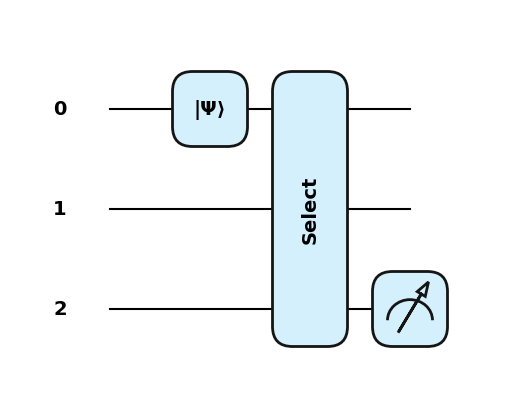

In [28]:
import matplotlib.pyplot as plt

dev2 = qml.device("default.qubit", wires=3)

# unitaries
ops = LCU_ops
# relabeling wires: 0 → 1, and 1 → 2
unitaries = [qml.map_wires(op, {0: 1, 1: 2}) for op in ops]


@qml.qnode(dev2)
def sel_circuit(qubit_value):
    qml.BasisState(qubit_value, wires=0)
    qml.Select(unitaries, control=0)
    return qml.expval(qml.PauliZ(2))

qml.draw_mpl(sel_circuit, style='pennylane')([0])
plt.show()

Based on the controlled operations, the circuit above will flip the
measured qubit if the input is $|1\rangle$ and leave it unchanged if the
input is $|0\rangle$. The output expectation values correspond to these
states:


In [29]:
print('Expectation value for input |0>:', sel_circuit([0]))
print('Expectation value for input |1>:', sel_circuit([1]))

Expectation value for input |0>: 1.0
Expectation value for input |1>: -1.0


We can now combine these to construct a full LCU circuit. Here we make
use of the `~.pennylane.adjoint`{.interpreted-text role="func"} function
as a convenient way to invert the prepare circuit. We have chosen an
input matrix that is already normalized, so it can be seen appearing
directly in the top-left block of the unitary describing the full
circuit \-\-- the mark of a successful block encoding.


In [30]:
@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit)()
print("A:\n", A, "\n")
print("Block-encoded A:\n")
print(np.real(np.round(output_matrix,2)))

A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 

Block-encoded A:

[[ 0.25  0.    0.    0.75 -0.43  0.    0.    0.43]
 [ 0.   -0.25  0.75  0.    0.    0.43  0.43  0.  ]
 [ 0.    0.75  0.25  0.    0.    0.43 -0.43  0.  ]
 [ 0.75  0.    0.   -0.25  0.43  0.    0.    0.43]
 [-0.43  0.    0.    0.43  0.75  0.    0.    0.25]
 [ 0.    0.43  0.43  0.    0.   -0.75  0.25  0.  ]
 [ 0.    0.43 -0.43  0.    0.    0.25  0.75  0.  ]
 [ 0.43  0.    0.    0.43  0.25  0.    0.   -0.75]]


Application: Projectors
=======================

Suppose we wanted to project our quantum state $|\psi\rangle$ onto the
state $|\phi\rangle$. We could accomplish this by applying the projector
$| \phi \rangle\langle \phi |$ to $|\psi\rangle$. However, we cannot
directly apply projectors as gates in our quantum circuits because they
are **not** unitary operations. We can instead use a simple LCU
decomposition which holds for any projector:

$$| \phi \rangle\langle \phi | = \frac{1}{2} \cdot \mathbb{I} + \frac{1}{2} \cdot (2 \cdot | \phi \rangle\langle \phi | - \mathbb{I})$$

Both terms in the expression above are unitary (try proving it for
yourself). We can now use this LCU decomposition to block-encode the
projector! As an example, let\'s block-encode the projector
$| 0 \rangle\langle 0 |$ that projects a state to the $|0\rangle$ state:

$$\begin{aligned}
| 0 \rangle\langle 0 | =  \begin{bmatrix}
1 & 0 \\
0 & 0 \\
\end{bmatrix}.
\end{aligned}$$


In [31]:
coeffs = np.array([1/2, 1/2])
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))

proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

Note that the second term in our LCU simplifies to a Pauli $Z$
operation. We can now construct a full LCU circuit and verify that
$| 0 \rangle\langle 0 |$ is block-encoded in the top left block of the
matrix.


In [32]:
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires="ancilla")

    # SEL
    qml.Select(proj_unitaries, control="ancilla")

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires="ancilla"))
    return qml.state()


output_matrix = qml.matrix(lcu_circuit, wire_order=["ancilla", 0])()
print("Block-encoded projector:\n")
print(np.real(np.round(output_matrix,2)))

Block-encoded projector:

[[ 1.  0. -0.  0.]
 [ 0. -0.  0. -1.]
 [-0.  0.  1.  0.]
 [ 0. -1.  0.  0.]]


Final thoughts
==============

LCUs and block encodings are often associated with advanced algorithms
that require the full power of fault-tolerant quantum computers. The
truth is that they are basic constructions with broad applicability that
can be useful for all kinds of hardware and simulators. If you\'re
working on quantum algorithms and applications in any capacity, these
are techniques that you should master, and PennyLane is equipped with
the tools to help you get there.


About the authors
=================
